# Lab 6 - Vision Transformer (ViT) and Visual Language Model (VLM)

In this lab, we will use our Encoder and Decoder implementations from the previous session to build a **Visual Language Model (VLM)** based on the **Vision Transformer (ViT)** architecture.


We will start by implementing a ViT-based image encoder, training it on the **COCO dataset**, and then integrating it with a Transformer-based text decoder to create a VLM capable of generating image captions.

## What is Vision Transformer (ViT)?

> The **Vision Transformer (ViT)** is a model that applies the Transformer architecture—originally designed for natural language processing—to image data.
> It divides an image into fixed-size patches, embeds these patches, and processes them using a standard Transformer encoder.

Let's look at the overview of the ViT architecture from the original paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929):

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab6_vision_transformer/figures/vit.png" alt="ViT Architecture" width="600"/>

As shown in the figure, the steps involved in the ViT architecture are:
1. **Patch Extraction**: The input image is divided into fixed-size patches (e.g. 16×16 pixels).
2. **Linear Embedding**: Each patch is flattened and projected into a vector of a specified embedding size using a linear layer. This embedding is similar to word embeddings in NLP—high-dimensional vectors representing words.
3. **Position Embedding**: Since Transformers do not inherently understand the order of input data, positional embeddings are added to the patch embeddings to retain spatial information. In NLP, we encode the position of words in a sentence; similarly, in ViT, we provide positional information for image patches.
4. **Transformer Encoder**: The sequence of patch embeddings (with positional information) is fed into a standard Transformer encoder. (The implementation of the Transformer encoder remains unchanged.)
5. **Classification Head**: For image classification tasks, a special **classification token (CLS token)** is added to the sequence of patch embeddings. The output corresponding to this token is used for classification.


## Below are some questions that might arise when implementing ViT:

### **1. Why do we need to split the image into patches?**

> Splitting the image into patches allows the ViT model to process the image in a way that is compatible with the Transformer architecture, which is designed to handle sequences of data.
> Each patch acts as a "token," similar to words in a sentence, enabling the model to learn relationships and dependencies between different parts of the image.
> This approach also reduces computational complexity, making it feasible to apply Transformers to high-resolution images.

For example, an image of size **224×224** split into **16×16** patches yields:
[
(224 / 16) \times (224 / 16) = 14 \times 14 = 196 \text{ patches.}
]
Each patch is flattened into a vector and projected into a higher-dimensional space (e.g. 768 dimensions) via a linear layer.
The sequence of these patch embeddings is then processed by the Transformer encoder.

If we did not split the image into patches, we would have to flatten the entire image into a single vector of size **224×224×3 = 150,528** (for RGB images), which would be computationally expensive and impractical for training.

### **2. Why do we need to add a CLS token?**

> In the Transformer architecture, the **CLS token** serves as a representative summary of the entire input sequence.
> When processing sequences—such as sentences in NLP or image patches in ViT—the model needs a way to aggregate information from all parts of the input.
> By prepending a CLS token, the model learns to encode global context into that token’s representation, effectively gathering information from all patches to make final predictions.
> Aggregating information is based on the attention mechanism, which allows the model to focus on relevant parts of the input.

You can think of the CLS token as a special element that "summarizes" the entire input sequence.

### **3. Why use ViT instead of traditional CNNs for image tasks?**

> ViT offers several advantages over traditional CNNs:
>
> * **Global context understanding:** ViT uses self-attention to capture relationships between all patches simultaneously, enabling better modeling of long-range dependencies.
> * **Scalability:** ViT scales efficiently with larger datasets and model sizes.
> * **Flexibility:** It can handle varying input sizes without needing convolutional kernels.

In contrast, CNNs are limited by their local receptive fields, which can make it difficult to capture global image context without stacking many layers or using large kernels.

Below is a visualization comparing the learned first-layer filters of a ViT and a CNN:

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab6_vision_transformer/figures/visualizing-conv-filters-vs-vit.png" alt="ViT vs CNN Filters" width="600"/>

## **Implementation Setup**

Now, let’s implement the ViT model in PyTorch.
For this lab, you’ll need to install a few additional libraries:

```bash
pip install pycocotools
pip install nltk
```

* **pycocotools** — used for working with the COCO dataset, which we’ll use for image captioning.
* **NLTK** — a natural language processing library used here for **BLEU score** calculation.

In [4]:
# !pip install pycocotools
# !pip install nltk
# !pip install torchmetrics

In [5]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import os

from PIL import Image
from tqdm import tqdm
from typing import Optional
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import MultilabelPrecision, MultilabelRecall, MultilabelF1Score

from pycocotools.coco import COCO
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import wandb

wandb.login()

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jrosa (deep-neural-network-course) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


## Copy Modules from Previous Labs

We will reuse the following modules from previous labs:

1. Positional Encoding
2. Single Attention Head
3. Multi-Head Attention
4. Encoder Block
5. Decoder Block
6. Causal Mask Generation

In [6]:
# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Visualization of Positional Encoding
def plot_positional_encoding(pe, max_len=200):
    plt.figure(figsize=(10, 5))
    plt.imshow(pe.pe[0, :max_len].cpu(), cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.title('Positional Encoding')
    plt.show()

# --- Single Attention Head ---
class Head(nn.Module):
    def __init__(self, emb_size, head_size, dropout=0.0, bias=False):
        super().__init__()
        self.key = nn.Linear(emb_size, head_size, bias=bias)
        self.query = nn.Linear(emb_size, head_size, bias=bias)
        self.value = nn.Linear(emb_size, head_size, bias=bias)
        self.scale = math.sqrt(head_size)
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None

    def forward(self, q, k, v, mask=None):
        Q = self.query(q)
        K = self.key(k)
        V = self.value(v)
        return self.scaled_dot_product_attention(Q, K, V, mask)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        self.attn_weights = attn.detach().cpu()
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        return out

# --- Multi-Head Attention ---
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0, bias=False):
        super().__init__()
        assert emb_size % num_heads == 0
        head_size = emb_size // num_heads
        self.heads = nn.ModuleList([Head(emb_size, head_size, dropout, bias) for _ in range(num_heads)])
        self.linear = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        out = torch.cat([h(q, k, v, mask) for h in self.heads], dim=-1)
        out = self.linear(out)
        out = self.dropout(out)
        return out

    def get_attention_maps(self):
        return [h.attn_weights for h in self.heads if h.attn_weights is not None]

# --- Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0, expansion=4):
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, num_heads, dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, emb_size * expansion),
            nn.ReLU(),
            nn.Linear(emb_size * expansion, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        attn_out = self.attn(x, x, x, mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0, expansion=4, use_cross_attn=False):
        super().__init__()
        self.use_cross_attn = use_cross_attn
        self.self_attn = MultiHeadAttention(emb_size, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(emb_size, num_heads, dropout) if use_cross_attn else None
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size) if use_cross_attn else None
        self.norm3 = nn.LayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, emb_size * expansion),
            nn.ReLU(),
            nn.Linear(emb_size * expansion, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x, enc_out: Optional[torch.Tensor] = None, tgt_mask: Optional[torch.Tensor] = None):
        if not self.use_cross_attn and enc_out is not None:
            raise ValueError("Cross-attention is not enabled in this DecoderBlock.")
        self_attn_out = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self_attn_out)
        if self.cross_attn is not None and enc_out is not None:
            cross_attn_out = self.cross_attn(x, enc_out, enc_out)
            x = self.norm2(x + cross_attn_out)
        ff_out = self.ff(x)
        x = self.norm3(x + ff_out)
        return x

# --- Causal Mask Generation ---
def make_causal_mask(seq_len):
    return torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)

## COCO Dataset Overview

As mentioned earlier, in this lab we will train our models using the COCO dataset.

COCO (Common Objects in Context) is a large-scale dataset designed for object detection, segmentation, and image captioning tasks.
It contains over 330,000 images, with more than 200,000 labeled images and over 1.5 million annotated object instances.
The dataset features images of complex, everyday scenes that contain multiple common objects in their natural contexts.

We will use the 2017 version of the COCO dataset, which includes:
- 118,000 training images
- 5,000 validation images
- 40,000 test images (Note: test images do not have publicly available annotations, so we will not use them in this lab.)
- Five captions per image, describing the visual content in natural language.
- 80 object categories for detection and segmentation tasks.

For more information about the COCO dataset, you can visit the official website: [COCO Dataset](https://cocodataset.org/#home).

Code below will automatically download the COCO 2017 dataset (images and annotations) if not already present in the specified directory.

In [7]:
# Create the base data directory
os.makedirs("./data", exist_ok=True)

# # === TRAIN ===
# if not os.path.exists("./data/train2017"):
#     print("Downloading train2017...")
#     !wget -q http://images.cocodataset.org/zips/train2017.zip -O train2017.zip
#     print("Unzipping train2017...")
#     !unzip -q train2017.zip -d ./data/
#     !rm train2017.zip
# else:
#     print("train2017 already exists, skipping download.")

# === VAL ===
if not os.path.exists("./data/val2017"):
    print("Downloading val2017...")
    !wget -q http://images.cocodataset.org/zips/val2017.zip -O val2017.zip
    print("Unzipping val2017...")
    !unzip -q val2017.zip -d ./data/
    !rm val2017.zip
else:
    print("val2017 already exists, skipping download.")

# === ANNOTATIONS ===
if not os.path.exists("./data/annotations"):
    print("Downloading annotations...")
    !wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O annotations.zip
    print("Unzipping annotations...")
    !unzip -q annotations.zip -d ./data/
    !rm annotations.zip
else:
    print("annotations already exist, skipping download.")

print("\nCOCO dataset is ready in ./data/")

Unzipping val2017...
Unzipping annotations...

COCO dataset is ready in ./data/


## Loading COCO Annotations

For captioning, we will use the `captions_train2017.json` and `captions_val2017.json` annotation files.

For instatnce segmentation, we will use the `instances_train2017.json` and `instances_val2017.json` annotation files.

Each annotation file can be loaded using the `pycocotools` library, specifically the `COCO` class, which provides a convenient interface for accessing image and annotation data.

Below is a simple example, how to load both annotation files, access image IDs, retrieve captions and instance annotations for a specific image.

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


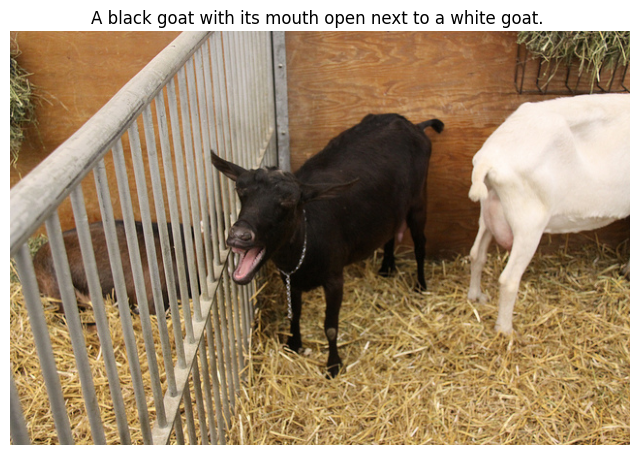

Image: 000000240754.jpg
Captions (5):
  - A black goat with its mouth open next to a white goat. 
  - A black and a white sheep inside of a fenced area.
  - a black sheep and others in a corral together
  - A sheep with its mouth open in a pen.
  - A small cow in a enclosure with straw on the floor. 

 Categories (1 unique): ['cow']
 Category IDs: [21, 21, 21]


In [8]:
# === Load datasets ===
coco_cap = COCO('./data/annotations/captions_val2017.json')
coco_inst = COCO('./data/annotations/instances_val2017.json')

# === Choose a random image ID (that exists in both datasets) ===
common_img_ids = list(set(coco_cap.getImgIds()) & set(coco_inst.getImgIds()))
img_id = random.choice(common_img_ids)

# === Load image info ===
img_info = coco_cap.loadImgs(img_id)[0]
img_path = os.path.join('./data/val2017', img_info['file_name'])
img = plt.imread(img_path)

# === Load captions ===
cap_ids = coco_cap.getAnnIds(imgIds=img_id)
cap_anns = coco_cap.loadAnns(cap_ids)
captions = [c['caption'] for c in cap_anns]

# === Load instance annotations ===
inst_ids = coco_inst.getAnnIds(imgIds=img_id)
inst_anns = coco_inst.loadAnns(inst_ids)
categories = [coco_inst.loadCats(a['category_id'])[0]['name'] for a in inst_anns]
categories_id = [a['category_id'] for a in inst_anns]

# === Display image ===
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title("\n".join(captions[:1]))  # show first 3 captions
plt.show()

# === Print metadata ===
print(f"Image: {img_info['file_name']}")
print(f"Captions ({len(captions)}):")
for c in captions:
    print("  -", c)
print(f"\n Categories ({len(set(categories))} unique): {sorted(set(categories))}")
print(f" Category IDs: {categories_id}")


# Part 1 - Vision Transformer

### Image preprocessing

Before feeding images into encoder, we need to preprocess them. It typically involves the following steps:
1. **Resizing**: Resize the image to a fixed size (e.g. 224x224 pixels) to ensure uniformity across the dataset.
2. **Normalization**: Normalize pixel values to a standard range (e.g. [0, 1] or [-1, 1]) to improve model convergence during training.
3. **Data Augmentation**: Apply random transformations (e.g. rotations, flips, color jitter) to increase dataset diversity and help the model generalize better.
4. **Conversion to Tensor**: Convert the image to a PyTorch tensor for compatibility with the model.
5. **Patch Extraction**: Divide the image into fixed-size patches (e.g. 16x16 pixels) and flatten each patch into a vector.
6. **Linear Projection**: Project each flattened patch into a higher-dimensional space using a linear layer to create patch embeddings.

First four steps are standard image preprocessing techniques, while the last two are specific to the ViT architecture.

Image below illustrates the patch extraction and embedding process:

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab6_vision_transformer/figures/patches.png" alt="Patch Extraction and Embedding" width="600"/>

Each patch is flattened and projected into a vector of a specified embedding size (e.g. 768 dimensions) via a linear layer. Code below implements the Patch Extraction step for visualisation purposes. **During implementing the ViT model, we will use a simpler approach by using a Conv2D layer with appropriate kernel size and stride to achieve the same effect.**

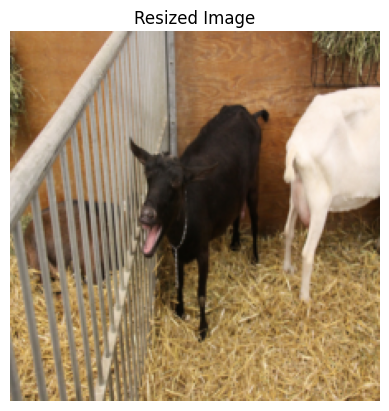

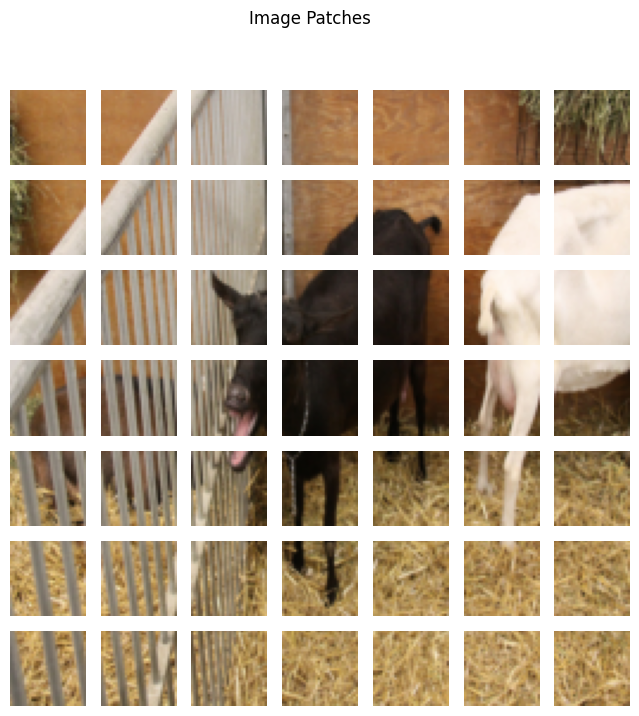

Image shape: torch.Size([1, 3, 224, 224])
Patches shape: torch.Size([1, 49, 3072])


In [9]:
def reshape_image(image, size=(224, 224)):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])(image)

def img_to_patches(img, patch_size=16):
    B, C, H, W = img.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image size must be divisible by patch size"
    patches = img.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, -1, patch_size * patch_size)
    return patches.permute(0, 2, 1, 3).reshape(B, -1, C * patch_size * patch_size)

# Example usage
img_resized = reshape_image(img)
plt.imshow(img_resized.permute(1, 2, 0))
plt.axis('off')
plt.title("Resized Image")
plt.show()

img_batch = img_resized.unsqueeze(0)
patches = img_to_patches(img_batch, patch_size=32)

# Visualize patches
num_patches = patches.shape[1]
p = int(math.sqrt(patches.shape[2] // 3))
g = int(math.sqrt(num_patches))

fig, axes = plt.subplots(g, g, figsize=(8, 8))
for i in range(g):
    for j in range(g):
        patch = patches[0, i*g + j].view(3, p, p).permute(1, 2, 0)
        axes[i, j].imshow(patch)
        axes[i, j].axis('off')
plt.suptitle("Image Patches")
plt.show()


print(f"Image shape: {img_batch.shape}")
print(f"Patches shape: {patches.shape}")


## Dataset and DataLoader

We will create a custom PyTorch `Dataset` class to handle loading and preprocessing of the COCO images and their corresponding captions and instance annotations.

During first part of the lab, we will focus only on image instance segmentation task. We will use them to pretrain our ViT encoder on multi-label classification task. Later, we will use the pretrained encoder in our VLM model for image captioning.

Our custom `COCODataset` class will be designed to both captioning and instance segmentation tasks. It will include:

1. **__init__**: accepts parameters such as the `root` directory of images, the path to the annotation file (both captions and instances), and any necessary transformations.
    - Initializes the COCO API for accessing captions and instance annotations.
    - Gets the set of image IDs for captions and instances (use python `set()`), and computes their intersection to ensure that only images with both types of annotations are included (just to be sure).
    - Creates a mapping from category IDs to indices for multi-label classification (dataset has 80 used categories, but all category IDs range from 1 to 90, with some IDs missing).
    - Create a inverse mapping from indices to category IDs for later use.

2. **__len__**: returns the total number of images in the dataset by returning the length of the intersected image IDs.

3. **__getitem__**: retrieves an image and its corresponding annotations (captions and instance categories) based on the provided index.
    - Gets the image ID from the intersected list.
    - Gets img_info from COCO API (use `self.coco_cap.loadImgs(img_id)[0]`).
    - Create the full image path by joining the root directory, mode (`train2017` or `val2017`), and the image file name from img_info.
    - Opens the image using PIL (`Image.open(img_path).convert("RGB")`).
    - If a transform is provided, applies it to the image.

    > Instance segmentation part:

    - Retrieves instance annotations for the image using `self.coco_inst.getAnnIds(imgIds=img_id)` and `self.coco_inst.loadAnns(inst_ann_ids)`.
    - Convert the list of instance annotations using prepared mapping dictionary.
    - Get a list of unique category indices present in the image (using `set` to avoid duplicates).
    - If no categories are present, assign a default category (e.g. [0]).

    > Captioning part:
    - Retrieves caption annotations for the image similarly like instance annotations.
    - Randomly selects one caption from the list of captions for the image and apply `.lower()` to change from uppercase to lowercase. If no captions are available, assigns a default caption (e.g. "no caption available" with lowercase).

    Returns: `image`, unique category indices `categories`, randomly selected caption `captions`, image ID `img_id` and `file_name`.


In [10]:
class COCODataset(Dataset):
    def __init__(self, root, annCapFile, annInsFile, transform=None):
        self.root = root
        self.transform = transform
        self.mode = 'train' if 'train' in annCapFile else 'val'

        # Initialize COCO APIs
        self.coco_cap = COCO(annCapFile)
        self.coco_inst = COCO(annInsFile)

        # Get image IDs that exist in both caption and instance sets
        cap_img_ids = set(self.coco_cap.getImgIds())
        inst_img_ids = set(self.coco_inst.getImgIds())
        self.img_ids = list(cap_img_ids.intersection(inst_img_ids))

        # Build category mapping (1–90 range, but only 80 are used)
        cats = self.coco_inst.loadCats(self.coco_inst.getCatIds())
        valid_cat_ids = [c['id'] for c in cats]  # e.g. [1, 2, 3, 4, 5, 6, 7, 8, ...]
        self.map_cls = {cat_id: i for i, cat_id in enumerate(valid_cat_ids)}
        self.inv_map_cls = {i: cat_id for cat_id, i in self.map_cls.items()}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco_cap.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, f"{self.mode}2017", img_info['file_name'])

        # Load image safely
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Instance annotations
        inst_ids = self.coco_inst.getAnnIds(imgIds=img_id)
        inst_anns = self.coco_inst.loadAnns(inst_ids)
        categories_id = [self.map_cls[a['category_id']] for a in inst_anns if a['category_id'] in self.map_cls]
        categories_id = list(set(categories_id))  # unique categories

        if len(categories_id) == 0:
            categories_id = [0]  # Assign default category if none found

        # Caption annotations
        cap_ids = self.coco_cap.getAnnIds(imgIds=img_id)
        cap_anns = self.coco_cap.loadAnns(cap_ids)

        # Select one random caption for diversity
        if len(cap_anns) > 0:
            cap_idx = random.randint(0, len(cap_anns) - 1)
            captions = cap_anns[cap_idx]['caption'].lower()
        else:
            captions = "no caption available."

        return {
            "image": image,
            "categories": categories_id,
            "captions": captions,
            "image_id": img_id,
            "file_name": img_info['file_name']
        }


Now, we will initialize the dataset and create DataLoaders for training and validation. Before that, we will define image transformations for preprocessing.

For image transformations, we will use `torchvision.transforms` to define a series of transformations that will be applied to each image when it is loaded from the dataset.

For the validation set, we will include:
- Resizing to a fixed size (224 x 224 pixels)
- Conversion to tensor
- Normalization using ImageNet mean and standard deviation (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

For the training set, we will include additional data augmentation techniques to improve model generalization:
- Resizing to a fixed size (256 x 256 pixels)
- Random cropping to 224 x 224 pixels using `transforms.RandomResizedCrop` (thanks to this, we will have slightly different images for each epoch)
- Random horizontal flipping using `transforms.RandomHorizontalFlip`
- Conversion to tensor
- Normalization using ImageNet mean and standard deviation

Additionally, we need to define a custom collate function for the DataLoader. This function will handle batching of images, multi-label targets, and captions:
- For images, we will stack them into a single tensor using `torch.stack`.
- For other data (categories, captions, img_ids, file_names), we will create lists to hold the values for each item in the batch.

Finally, we will create DataLoaders for both training and validation datasets using the custom collate function. We will enable shuffling for the training DataLoader and pin memory for both DataLoaders to improve performance. In my case, I will use a batch size of 32 and num workers to 12, but you can adjust it based on your hardware capabilities.

In [11]:
# Validation: only resize + normalize
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),  # fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Training: augmentations for better generalization
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),             # first resize slightly larger
    transforms.RandomResizedCrop(224),         # random crop to target size
    transforms.RandomHorizontalFlip(),         # random flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ============================
# Create datasets
# ============================

train_dataset = COCODataset(
    root='./data/',
    annCapFile='./data/annotations/captions_val2017.json',
    annInsFile='./data/annotations/instances_val2017.json',
    transform=transform_train
)

val_dataset = COCODataset(
    root='./data/',
    annCapFile='./data/annotations/captions_val2017.json',
    annInsFile='./data/annotations/instances_val2017.json',
    transform=transform_val
)

# ============================
# Custom collate function
# ============================

def coco_collate_fn(batch):
    images = torch.stack([b["image"] for b in batch])
    categories = [b["categories"] for b in batch]
    captions = [b["captions"] for b in batch]
    img_ids = [b["image_id"] for b in batch]
    file_names = [b["file_name"] for b in batch]
    return images, categories, captions, img_ids, file_names

# ============================
# Create DataLoaders
# ============================

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    collate_fn=coco_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    collate_fn=coco_collate_fn
)

# ============================
# Example usage / sanity check
# ============================

for images, categories, captions, img_ids, file_names in train_loader:
    print(f"Batch size: {len(images)}")
    print(f"Image tensor shape: {images.shape}")
    print("First image captions:", captions[0])
    print("First image categories:", categories[0])
    print("First image ID:", img_ids[0])
    print("First image file name:", file_names[0])
    break


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch size: 32
Image tensor shape: torch.Size([32, 3, 224, 224])
First image captions: a bowl has a soup with potatoes and vegetables. 
First image categories: [0, 50, 51, 45]
First image ID: 105335
First image file name: 000000105335.jpg


## Vision Transformer (ViT) Implementation

Now, let's implement the Vision Transformer (ViT) model in PyTorch.

As discussed earlier, the ViT model consists of several key components:
1. **Patch Embedding Layer**: This layer will take the input image and divide it into patches, flatten each patch, and project it into a higher-dimensional space using a linear layer. We can achieve this using a `Conv2D` layer with appropriate kernel size and stride.
2. **Positional Encoding**: Since Transformers do not inherently understand the order of input data, we will add positional encodings to the patch embeddings to retain spatial information.
3. **Transformer Encoder**: We will use the `EncoderBlock` class from the previous lab to build the Transformer encoder. We will stack multiple encoder blocks to form the complete encoder.
4. **Classification Head** : For image classification tasks, we will add a classification head that takes the output corresponding to the CLS token and passes it through a linear layer to produce class logits.


Below is the complete implementation of the ViT model in PyTorch:

1. **__init_**: Initializes the ViT model with parameters such as image size, patch size, embedding size, number of encoder layers, number of attention heads, feedforward dimension, number of classes, dropout rate, and device.
    - First, checks if the image size is divisible by the patch size (using an assertion).
    - Calculates the number of patches based on the image size and patch size.
    - Initializes the patch embedding layer using `Conv2D` with kernel size and stride equal to the patch size.
    - Initializes the positional encoding layer using the `PositionalEncoding` class from the previous lab (remember to set `max_len` to `num_patches + 1` to account for the CLS token).
    - Initializes the CLS token as a learnable parameter (using `nn.Parameter` and `torch.zeros` (1, 1, emb_size)).
    - Creates a list of encoder blocks.
    - Initializes the classification head as a linear layer that maps the embedding size to the number of classes.

2. **forward**: Defines the forward pass of the ViT model.
    - Takes an input image tensor of shape (batch_size, in_channels, img_size, img_size).
    - Passes the input image through the patch embedding layer to obtain patch embeddings.
    - Flattens and transposes the patch embeddings to shape (batch_size, num_patches, emb_size).
    - Expands the CLS token to match the batch size and concatenates it with the patch embeddings (to the left)
    - Adds positional encodings to the combined embeddings.
    - Passes the embeddings through each encoder block in sequence.
    - Extracts the output corresponding to the CLS token (from the first position in the sequence).
    - Passes the CLS token output through the classification head to obtain class logits.




In [12]:
class VisionTransformer(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=32,
                 in_channels=3,
                 emb_size=128,
                 num_heads=8,
                 num_layers=6,
                 expansion=4,
                 dropout=0.1,
                 num_classes=80,
                 device='cpu'):

        super().__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2   # ✅ Number of patches

        # Patch embedding: use Conv2D to extract and project patches to embedding space
        self.patch_embedding = nn.Conv2d(
            in_channels, emb_size,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))

        # Positional encoding
        self.positional_encoding = PositionalEncoding(
            emb_size, max_len=self.num_patches + 1
        )

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderBlock(emb_size, num_heads, expansion=expansion, dropout=dropout) for _ in range(num_layers)
        ])

        # Classification head
        self.classifier = nn.Linear(emb_size, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.xavier_uniform_(self.classifier.weight)
        if self.classifier.bias is not None:
            nn.init.constant_(self.classifier.bias, 0)

    def forward(self, x):
        B = x.size(0)

        # (B, emb_size, H/patch, W/patch)
        x = self.patch_embedding(x)

        # Flatten spatial dimensions: (B, emb_size, num_patches)
        x = x.flatten(2).transpose(1, 2)  # → (B, num_patches, emb_size)

        # Expand and concatenate CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)      # (B, 1, emb_size)
        x = torch.cat((cls_tokens, x), dim=1)              # (B, num_patches + 1, emb_size)

        # Add positional encodings
        x = self.positional_encoding(x)

        # Pass through all encoder layers
        for layer in self.encoder_layers:
            x = layer(x)

        # Extract CLS token output
        cls = x[:, 0]                                      # (B, emb_size)

        # Classification head
        out = self.classifier(cls)                         # (B, num_classes)
        return out


Let's instantiate the ViT model with appropriate parameters and check its architecture, number of parameters, and a sample forward pass with data from the DataLoader.

You can adjust the parameters to check how they affect the model size and performance. For example, you can try different patch sizes (e.g. 8, 16, 32), embedding sizes (e.g. 256, 512, 768), number of encoder layers (e.g. 6, 12, 24), and number of attention heads (e.g. 4, 8, 12). Remember that larger models may require more computational resources and longer training times.

In [13]:
# Example usage
model = VisionTransformer(img_size=224,
                          patch_size=32,
                          num_classes=80,
                          in_channels=3,
                          emb_size=256,
                          num_heads=8,
                          num_layers=6,
                          expansion=4,
                          dropout=0.5,
                          ).to(device)

print(model)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f}M")

for images, categories, captions, img_ids, file_names in train_loader:
    images = images.to(device)
    outputs = model(images)
    print(f"Input shape: {images.shape}")
    print(f"Output shape: {outputs.shape}")  # Should be (batch_size, num_classes)
    break

VisionTransformer(
  (patch_embedding): Conv2d(3, 256, kernel_size=(32, 32), stride=(32, 32))
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderBlock(
      (attn): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (key): Linear(in_features=256, out_features=32, bias=False)
            (query): Linear(in_features=256, out_features=32, bias=False)
            (value): Linear(in_features=256, out_features=32, bias=False)
            (dropout): Dropout(p=0.5, inplace=False)
          )
        )
        (linear): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024,

Below is a Trainer class that will handle the training and validation loops for our ViT model. It will include methods:
1. **__init__**: Initializes the Trainer with the model, device, optimizer, loss function, training and validation DataLoaders, number of epochs, and learning rate scheduler. To speed up training, we compile the model using `torch.compile`. If `use_wandb` is set to True, it initializes Weights & Biases for experiment tracking. Because COCO dataset consists of 80 categories and for each image we have only few categories (e.g. 3) present, we will use multi-label classification approach. To handle multi-label classification, we will use `BCEWithLogitsLoss` as the loss function. To prevent from large class imbalance issue, we will set `pos_weight` parameter of the loss function to a tensor with values equal to 25 ((80 - 3) / 3 ~ 25).
2. **multilabel_mean_accuracy**: Computes the mean accuracy for multi-label classification tasks (only for active ground truth labels).
3. **multilabel_metrics**: Computes precision, recall, and F1-score for multi-label classification tasks.
4. **make_multihot_targets**: Converts a list of category indices into multi-hot encoded vectors. Because COCO dataset is challenging, we select only first k categories (e.g. k=3) for each image to create multi-hot vectors (we focus only on few categories per image).
5. **train_one_epoch**: Performs one epoch of training, iterating over the training DataLoader, computing loss, updating model weights and logging metrics.
6. **validate_epoch**: Performs one epoch of validation, iterating over the validation DataLoader, computing loss, accuracy, precision, recall, and F1-score, and logging metrics.
7. **predict**: Generates single batch predictions using the test (or validation) DataLoader.
8. **save_best_model**: Saves the model state dictionary to a specified file path.
9. **fit**: The main training loop that iterates over the specified number of epochs, calling `train_one_epoch` and `validate` methods, and saving the best model based on validation loss.

In [14]:
class TrainerViT:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader=None,
        use_wandb=True,
        num_classes=80,
        lr=1e-4,
        weight_decay=1e-3,
        epochs=25,
        run_name="Your name",
        device='cpu'
    ):
        self.device = device
        self.model = torch.compile(model)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader if test_loader is not None else val_loader
        self.num_classes = num_classes
        self.epochs = epochs
        self.use_wandb = use_wandb

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([25.0] * num_classes).to(device))

        # W&B setup
        if self.use_wandb:
            wandb.init(
                project="lab6-vit",
                entity="deep-neural-network-course",
                name=run_name,
                group="Vision Transformer",
                settings=wandb.Settings(save_code=False)
            )

        self.best_val_loss = float('inf')

    def multilabel_mean_accuracy(self, outputs, targets, threshold=0.5):
        preds = (torch.sigmoid(outputs) > threshold).float()
        correct = (preds == targets)[targets == 1].float().mean()
        return correct

    def multilabel_metrics(self, outputs, targets, threshold=0.5):
        preds = (torch.sigmoid(outputs) > threshold).float()
        precision = MultilabelPrecision(num_labels=targets.shape[1], average='macro').to(self.device)(preds, targets)
        recall = MultilabelRecall(num_labels=targets.shape[1], average='macro').to(self.device)(preds, targets)
        f1 = MultilabelF1Score(num_labels=targets.shape[1], average='macro').to(self.device)(preds, targets)
        return precision, recall, f1

    def make_multihot_targets(self, categories, top_k=3):
        """Turn the first top_k category indices into a multi-hot vector."""
        batch_size = len(categories)
        targets = torch.zeros(batch_size, self.num_classes, dtype=torch.float32)
        for i, cats in enumerate(categories):
            for c in cats[:top_k]:  # use first 3 labels
                if c < self.num_classes:
                    targets[i, c] = 1.0
        return targets.to(self.device)

    def train_one_epoch(self, epoch):
        self.model.train()
        total_loss = 0

        for images, categories, _, _, _ in tqdm(self.train_loader, desc=f"Epoch {epoch+1} [Train]"):
            images = images.to(self.device)
            targets = self.make_multihot_targets(categories, 3)

            self.optimizer.zero_grad()
            outputs = self.model(images)

            loss = self.criterion(outputs, targets)

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(self.train_loader)

        print(f"\n[Epoch {epoch+1}] Train Loss: {avg_loss:.4f}")

        if self.use_wandb:
            wandb.log({
                "Epoch": epoch + 1,
                "Train/Loss": avg_loss,
            })

        return avg_loss

    def validate(self, epoch):
        self.model.eval()
        val_loss, val_mean_acc = 0, 0
        val_precision, val_recall, val_f1 = 0, 0, 0

        with torch.no_grad():
            for images, categories, _, _, _ in tqdm(self.val_loader, desc=f"Epoch {epoch+1} [Val]"):
                images = images.to(self.device)
                targets = self.make_multihot_targets(categories, 3)

                outputs = self.model(images)
                loss = self.criterion(outputs, targets)

                mean_acc = self.multilabel_mean_accuracy(outputs, targets)
                precision, recall, f1 = self.multilabel_metrics(outputs, targets)

                val_mean_acc += mean_acc.item()
                val_precision += precision.item()
                val_recall += recall.item()
                val_f1 += f1.item()

                val_loss += loss.item()

        avg_val_loss = val_loss / len(self.val_loader)
        avg_val_mean_acc = val_mean_acc / len(self.val_loader)

        avg_val_precision = val_precision / len(self.val_loader)
        avg_val_recall = val_recall / len(self.val_loader)
        avg_val_f1 = val_f1 / len(self.val_loader)

        print(f"Validation Loss: {avg_val_loss:.4f}, "
              f"Mean Label Acc: {avg_val_mean_acc*100:.2f}% "
              f"Precision: {avg_val_precision*100:.2f}%, Recall: {avg_val_recall*100:.2f}%, F1: {avg_val_f1*100:.2f}%")

        if self.use_wandb:
            wandb.log({
                "Val/Loss": avg_val_loss,
                "Val/Mean Label Accuracy": avg_val_mean_acc,
                "Val/Precision": avg_val_precision,
                "Val/Recall": avg_val_recall,
                "Val/F1 Score": avg_val_f1
            })

        return avg_val_loss

    def predict(self):
        images, categories, _, _, _ = next(iter(self.test_loader))
        images = images.to(self.device)
        outputs = self.model(images)
        return outputs, categories, images

    def save_best_model(self):
        torch.save(self.model.state_dict(), "best_vit_model.pth")
        print("Best model saved.")

    def fit(self):
        for epoch in range(self.epochs):
            self.train_one_epoch(epoch)
            val_loss = self.validate(epoch)

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_best_model()

            self.scheduler.step()

        if self.use_wandb:
            wandb.finish()


Initialize the Trainer and start training the ViT model. You can adjust the hyperparameters such as learning rate, weight decay, and number of epochs.

In [15]:
!export TORCHDYNAMO_VERBOSE=1

trainer = TrainerViT(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    use_wandb=True,
    lr=1e-4,
    weight_decay=1e-3,
    epochs=10,
    run_name="Jan Rosa"
)

trainer.fit()

Epoch 1 [Train]: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]



[Epoch 1] Train Loss: 0.9989


Epoch 1 [Val]:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Val]: 100%|██████████| 157/157 [01:09<00:00,  2.25it/s]


Validation Loss: 0.8947, Mean Label Acc: 54.93% Precision: 3.41%, Recall: 17.21%, F1: 5.07%
Best model saved.


Epoch 2 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2 [Train]: 100%|██████████| 157/157 [00:47<00:00,  3.34it/s]



[Epoch 2] Train Loss: 0.9374


Epoch 2 [Val]: 100%|██████████| 157/157 [00:36<00:00,  4.29it/s]


Validation Loss: 0.8763, Mean Label Acc: 57.11% Precision: 4.33%, Recall: 18.55%, F1: 6.15%
Best model saved.


Epoch 3 [Train]: 100%|██████████| 157/157 [00:45<00:00,  3.42it/s]



[Epoch 3] Train Loss: 0.9185


Epoch 3 [Val]: 100%|██████████| 157/157 [00:35<00:00,  4.38it/s]


Validation Loss: 0.8521, Mean Label Acc: 60.41% Precision: 4.61%, Recall: 20.63%, F1: 6.76%
Best model saved.


Epoch 4 [Train]: 100%|██████████| 157/157 [00:45<00:00,  3.49it/s]



[Epoch 4] Train Loss: 0.9041


Epoch 4 [Val]: 100%|██████████| 157/157 [00:36<00:00,  4.24it/s]


Validation Loss: 0.8427, Mean Label Acc: 65.09% Precision: 5.07%, Recall: 23.53%, F1: 7.48%
Best model saved.


Epoch 5 [Train]: 100%|██████████| 157/157 [00:44<00:00,  3.49it/s]



[Epoch 5] Train Loss: 0.8924


Epoch 5 [Val]: 100%|██████████| 157/157 [00:37<00:00,  4.18it/s]


Validation Loss: 0.8411, Mean Label Acc: 66.10% Precision: 5.13%, Recall: 24.40%, F1: 7.67%
Best model saved.


Epoch 6 [Train]: 100%|██████████| 157/157 [00:45<00:00,  3.48it/s]



[Epoch 6] Train Loss: 0.8795


Epoch 6 [Val]: 100%|██████████| 157/157 [00:37<00:00,  4.16it/s]


Validation Loss: 0.8213, Mean Label Acc: 67.96% Precision: 5.39%, Recall: 25.61%, F1: 8.19%
Best model saved.


Epoch 7 [Train]: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s]



[Epoch 7] Train Loss: 0.8684


Epoch 7 [Val]: 100%|██████████| 157/157 [00:37<00:00,  4.17it/s]


Validation Loss: 0.8145, Mean Label Acc: 67.73% Precision: 5.64%, Recall: 25.47%, F1: 8.46%
Best model saved.


Epoch 8 [Train]: 100%|██████████| 157/157 [00:45<00:00,  3.48it/s]



[Epoch 8] Train Loss: 0.8607


Epoch 8 [Val]: 100%|██████████| 157/157 [00:37<00:00,  4.18it/s]


Validation Loss: 0.8060, Mean Label Acc: 69.81% Precision: 5.78%, Recall: 26.80%, F1: 8.71%
Best model saved.


Epoch 9 [Train]: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s]



[Epoch 9] Train Loss: 0.8539


Epoch 9 [Val]: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Validation Loss: 0.8008, Mean Label Acc: 69.68% Precision: 5.76%, Recall: 26.59%, F1: 8.69%
Best model saved.


Epoch 10 [Train]: 100%|██████████| 157/157 [00:46<00:00,  3.36it/s]



[Epoch 10] Train Loss: 0.8483


Epoch 10 [Val]: 100%|██████████| 157/157 [00:37<00:00,  4.23it/s]

Validation Loss: 0.8004, Mean Label Acc: 70.03% Precision: 5.82%, Recall: 26.86%, F1: 8.77%
Best model saved.


Epoch,▁▂▃▃▄▅▆▆▇█
Train/Loss,█▅▄▄▃▂▂▂▁▁
Val/F1 Score,▁▃▄▆▆▇▇███
Val/Loss,█▇▅▄▄▃▂▁▁▁
Val/Mean Label Accuracy,▁▂▄▆▆▇▇███
Val/Precision,▁▄▄▆▆▇▇███
Val/Recall,▁▂▃▆▆▇▇███
Epoch,10
Train/Loss,0.8483
Val/F1 Score,0.08771
Val/Loss,0.80042


To visualise the predictions, we will first load the best saved model, then we will use `trainer.predict()` method to generate predictions on a batch of validation images. We need to invert the normalization applied during preprocessing to display the images correctly. We will also apply a sigmoid function to the model outputs to obtain probabilities for each class.

**Note: You can adjust the threshold value (e.g. 0.5, 0.7, 0.9) to control the sensitivity of the predictions. A lower threshold will result in more predicted classes, while a higher threshold will yield fewer classes.**

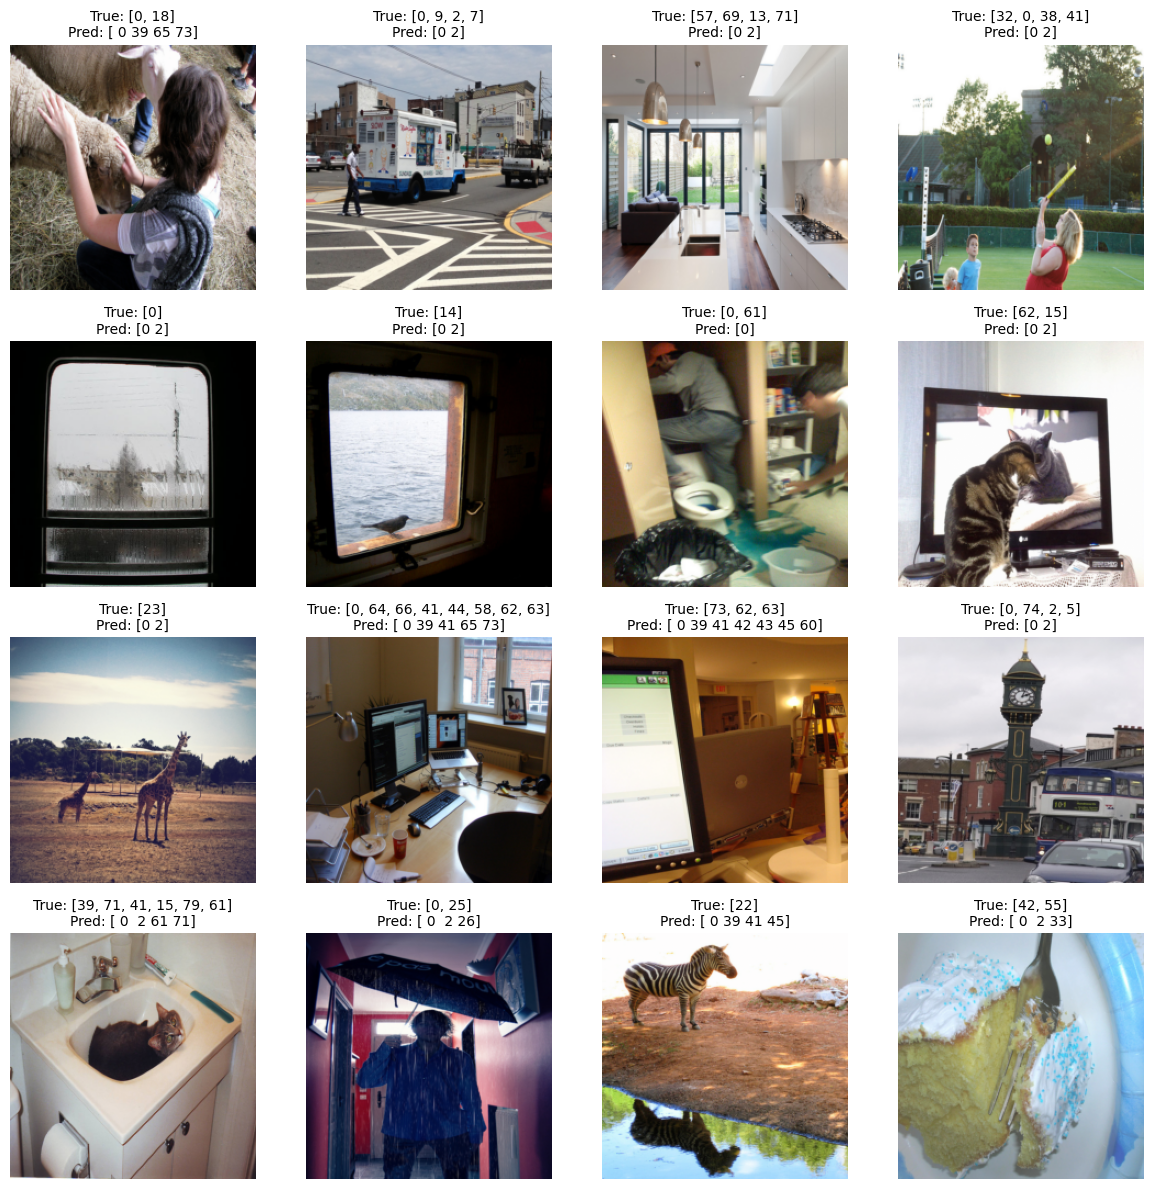

In [16]:
trainer.model.load_state_dict(torch.load("best_vit_model.pth", weights_only=True)) # load our or provided weights
outputs, categories, images = trainer.predict()

# Visualize some predictions
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i >= len(images):
        break
    img = inv_normalize(images[i]).cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    true_cats = categories[i]
    pred_probs = torch.sigmoid(outputs[i]).detach().cpu().numpy()
    pred_cat_indices = np.where(pred_probs > 0.75)[0]
    ax.set_title(f"True: {true_cats}\nPred: {pred_cat_indices}", fontsize=10)
plt.tight_layout()
plt.show()

# Part 2 - Visual Language Model (VLM)

## **What is a Visual Language Model (VLM)?**

> A **Visual Language Model (VLM)** is a model that combines **vision** and **language understanding** within a single architecture.
> It learns to connect visual content (images or videos) with textual descriptions (captions, questions, or instructions).
> This allows the model to generate, interpret, or reason about text in the context of images.

In practice, a VLM usually consists of two main components:

1. **Image Encoder (Vision Backbone)**
   Extracts high-level visual features from an input image.

   * This can be a **ViT**, **CNN**, or another vision model.
   * The encoder transforms the image into a sequence of embeddings representing visual concepts.

2. **Text Decoder (Language Backbone)**
   Generates or understands text based on the visual features.

   * Typically implemented as a **Transformer-based decoder** (similar to GPT or standard Transformer decoders).
   * It conditions its text generation on the encoded image representation.

Together, these components enable tasks such as:

* **Image captioning** (describing an image in natural language)
* **Visual question answering (VQA)**
* **Image-text retrieval**
* **Multimodal reasoning**

In this lab, we will build a **VLM for image captioning**, where:

* The **ViT** acts as the **image encoder**, and
* The **Transformer-based text decoder** generates captions conditioned on the visual embeddings.


### **How Does a VLM Work for Image Captioning?**

1. The input image is passed through the **ViT encoder** to obtain a sequence of visual feature embeddings (one per image patch).
2. These embeddings are passed to the **text decoder**, which generates words one by one, attending to the image features at each step.
3. The decoder continues generating tokens until it produces an end-of-sequence symbol (`<EOS>`), forming a complete caption.

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab6_vision_transformer/figures/vlm.png" alt="VLM Architecture" width="600"/>

We will start by preparing the text data for training the VLM.

To get the vocabulary, we will extract all unique characters from the captions in the COCO dataset (both training and validation sets). To reduce the vocabulary size, we will convert all characters to lowercase. We will also add special tokens for padding (`<PAD>`), start of sequence (`<SOS>`), and end of sequence (`<EOS>`).

We will then create mappings from characters to indices (`char2idx`) and from indices to characters (`idx2char`). These mappings will be used to encode captions into sequences of indices for training and to decode predicted sequences back into text.

Our vocabulary should look something like this consist of 60-70 characters, including letters, digits, punctuation, and special tokens.

In [17]:
def get_unique_characters(files):
    captions = []
    for file in files:
        coco = COCO(file)
        captions += [ann['caption'].lower()
                      for ann in coco.anns.values()]

    all_text = " ".join(captions)
    unique_chars = set(all_text)
    char_vocab = sorted(unique_chars)
    char_vocab.insert(0, '<PAD>')  # Padding token
    char_vocab.insert(1, '<EOS>')  # End of sequence token
    char_vocab.insert(2, '<SOS>')  # Start of sequence token

    char2idx = {ch: idx for idx, ch in enumerate(char_vocab)}
    idx2char = {idx: ch for ch, idx in char2idx.items()}
    return char2idx, idx2char, char_vocab

char2idx, idx2char, char_vocab = get_unique_characters([
    './data/annotations/captions_train2017.json',
    './data/annotations/captions_val2017.json'
])

print(f"Unique characters ({len(char2idx)}): {char2idx}")
encode = lambda text: [char2idx.get(ch, char2idx[' ']) for ch in text]
decode = lambda indices: ''.join([idx2char[idx] for idx in indices if idx in idx2char and idx2char[idx] not in ['<SOS>', '<EOS>']])

# Example usage
for images, categories, captions, img_ids, file_names in train_loader:
    print("-" * 50)
    print("Text:", captions[0][:10])  # show first 3 captions
    print("Encoded:", encode(captions[0][:10]))
    break

loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Unique characters (67): {'<PAD>': 0, '<EOS>': 1, '<SOS>': 2, '\n': 3, ' ': 4, '!': 5, '"': 6, '#': 7, '$': 8, '%': 9, '&': 10, "'": 11, '(': 12, ')': 13, '*': 14, '+': 15, ',': 16, '-': 17, '.': 18, '/': 19, '0': 20, '1': 21, '2': 22, '3': 23, '4': 24, '5': 25, '6': 26, '7': 27, '8': 28, '9': 29, ':': 30, ';': 31, '=': 32, '>': 33, '?': 34, '@': 35, '[': 36, '\\': 37, ']': 38, '_': 39, '`': 40, 'a': 41, 'b': 42, 'c': 43, 'd': 44, 'e': 45, 'f': 46, 'g': 47, 'h': 48, 'i': 49, 'j': 50, 'k': 51, 'l': 52, 'm': 53, 'n': 54, 'o': 55, 'p': 56, 'q': 57, 'r': 58, 's': 59, 't': 60, 'u': 61, 'v': 62, 'w': 63, 'x': 64, 'y': 65, 'z': 66}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


--------------------------------------------------
Text: an elephan
Encoded: [41, 54, 4, 45, 52, 45, 56, 48, 41, 54]


Based on our vocabulary, we are implementing the `generate_tokens` function, which prepares the input and output tokens for the decoder along with the corresponding padding mask.

Similarly to our previous lab with MiniGPT, the input tokens are shifted by one position relative to the output tokens. The input sequence begins with the `<SOS>` (Start Of Sequence) token, which initializes the generation process. The output sequence ends with the `<EOS>` (End Of Sequence) token, which marks the end of text generation.

Since we are training data in batches and each caption differs in length, we need to pad all token sequences in a batch to the same maximum length. To achieve this, we use `<PAD>` tokens to fill positions after the last token in each sequence. Because the `<PAD>` token was inserted as the first token during vocabulary initialization, we can initialize our sequences with zeros (representing `<PAD>`) and then overwrite only the non-zero positions with actual tokens.

To prevent the model from attending to these padded positions, we generate a `padding_mask` based on the input tokens by checking for non-zero values in the input sequence. We then combine this mask with the `causal_mask` using a simple bitwise `&` operation.

> **Note:** The `generate_causal_mask` function produces a mask of shape `(seq_length, seq_length)`, while the `padding_mask` has shape `(batch, seq_length)`. To combine them for multi-head attention, we need to broadcast them to a common shape `(batch, seq_length, seq_length)` by expanding the `padding_mask` along the middle dimension (`[:, None, :]`) and the `causal_mask` along the batch dimension (`[None, :, :]`).


['a yellow dog smelling the toilet paper in a bathroom.', 'a group of old people sitting on a bench talking ', 'a man taking a selfie in front of a mirror.', 'an airplane flying high in the sky on a partly cloudy day.', 'a passenger bus that is driving down a street.', 'the man is riding the surfboard on the water. ', 'two men guiding cows while behind on horses. ', 'a plate full of tasty looking assorted baked items.', 'a pastry displayed on a wood table in a store setting.', 'a man taking a selfie while eating pizza.', 'a person is on skis on a snow trail.', 'a woman holding a camera is taking a picture.', 'a man in a hat balancing his skateboard on a highway barrier.', 'a brown bear is standing on the rocks facing forward.', 'a red fire hydrant with a sticker of several animals on it', 'a urinal hanging on a wall in between two stalls', 'a woman on a snow board riding down a hill.', 'a red traffic light at night next to a christmas tree.', 'a white sink sitting next to a toilet.', '

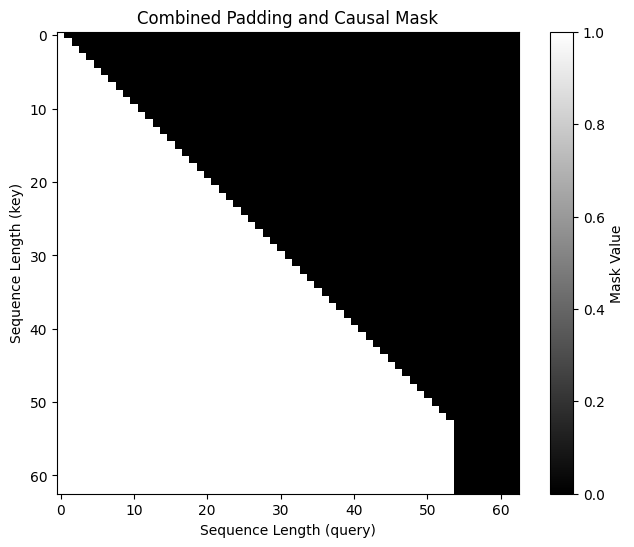

In [18]:
def generate_tokens(captions, encoder):
    B = len(captions)
    max_len = max(len(c) for c in captions) + 2  # +2 for SOS and EOS tokens
    encoded_captions = [encoder(c) for c in captions]

    # Initialize with PAD tokens (index 0)
    input_ids = torch.zeros(B, max_len, dtype=torch.long)
    output_ids = torch.zeros(B, max_len, dtype=torch.long)

    for i, enc in enumerate(encoded_captions):
        # Input: SOS + encoded caption
        input_ids[i, 0] = char2idx['<SOS>']  # SOS token
        input_ids[i, 1:len(enc)+1] = torch.tensor(enc)

        # Output: encoded caption + EOS
        output_ids[i, :len(enc)] = torch.tensor(enc)
        output_ids[i, len(enc)] = char2idx['<EOS>']  # EOS token

    # Padding mask: 1 for real tokens, 0 for padding
    padding_mask = (input_ids != char2idx['<PAD>']).float()

    return input_ids, output_ids, padding_mask

# Example usage
for images, categories, captions, img_ids, file_names in train_loader:
    print(captions)
    input_ids, output_ids, padding_mask = generate_tokens([c for c in captions], encode)
    print("Input IDs:", input_ids[0])
    print("Output IDs:", output_ids[0])
    print("Padding Mask:", padding_mask[0])
    break

# Merging both masks using multiplication (for float tensors)
causal_mask = make_causal_mask(input_ids.size(1))
final_mask = padding_mask[:, None, :] * causal_mask[None, :, :]

# visualize the mask as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(final_mask[0].cpu()[0, :, :], cmap='gray')
plt.title("Combined Padding and Causal Mask")
plt.xlabel("Sequence Length (query)")
plt.ylabel("Sequence Length (key)")
plt.colorbar(label="Mask Value")
plt.show()

## VLM Model Implementation

We will now implement our **Vision-Language Model (VLM)**.

---

### Vision Encoder

We start with the `VisionEncoder` class.
Since it is mostly the same model as in **Part 1 (ViT)**, we inherit from it and modify only the `forward` method.

Because we use this encoder solely to extract features from image patches (not for classification), we process all patches **without the CLS token** and return them directly after the last encoder layer.

---

### Text Decoder

Our `TextDecoder` class has a similar structure to the **MiniGPT** model from the previous lab.
The main difference is that now the encoder features are passed into the decoder through cross-attention layers.

1. In `__init__`, we initialize the following components:

   * **Token embedding** layer
   * **PositionalEncoding**
   * A list of **DecoderBlock** layers (with `use_cross_attn=True`)
   * A **Linear classifier** for output logits

2. In the `forward` method, the data is processed in sequence:

   ```
   token_embedding → positional_encoding → decoder_layers → classifier
   ```

   Each decoder layer receives `enc_out` (encoder features) as input for cross-attention.

   * If `tgt_captions` is provided, we compute the **cross-entropy loss** (ignoring `<PAD>` tokens).
   * Otherwise, we return only the logits with `loss=None`.

3. The `generate` method differs the most from MiniGPT:

   * Initializes:

     * `generated` → tensor of shape `(B, 1)` filled with `start_token` tokens
     * `finished` → tensor of shape `(B)` with `False` values
   * Iterates for `range(max_len - 1)`:

     * Generates a **causal mask** from the current sequence length
     * Processes the sequence with `enc_out` and `tgt_mask`
     * Takes the **last prediction** from the sequence and scales it by `temperature`
     * If `top_k > 0`, applies **top-k filtering** (replacing values below the cutoff with `-inf`)
     * Samples the **next token** using `softmax` and `torch.multinomial`
     * Keeps `<EOS>` for sequences that are already finished
     * Appends `next_token` to `generated`
     * Marks sequences that predicted `<EOS>` as finished
     * If all sequences are finished (`finished.all()`), breaks early

---

### Image Captioning Model

Finally, the **Image Captioning Model** integrates both components.
It processes the input images through the **Vision Encoder** to obtain feature representations and then passes these, along with the caption tokens, target captions, and target mask, into the **Text Decoder** to generate or train captions.


In [24]:
class VisionEncoder(VisionTransformer):
    def __init__(self,
                 img_size=224,
                 patch_size=32,
                 in_channels=3,
                 emb_size=128,
                 num_heads=8,
                 num_layers=6,
                 expansion=4,
                 dropout=0.1):

        super().__init__(img_size, patch_size, in_channels, emb_size, num_heads, num_layers, expansion, dropout)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embedding(x)                    # (B, emb_size, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)               # (B, num_patches, emb_size)

        # Add positional encoding (without CLS token)
        x = self.positional_encoding(x)                # (B, num_patches, emb_size)

        # Pass through encoder layers
        for layer in self.encoder_layers:
            x = layer(x)
        return x
class TextDecoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 emb_size=128,
                 num_heads=8,
                 num_layers=6,
                 expansion=4,
                 dropout=0.1,
                 max_len=128):

        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, max_len)

        self.decoder_layers = nn.ModuleList([
            DecoderBlock(emb_size, num_heads, dropout, expansion, use_cross_attn=True)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(emb_size, vocab_size)

    def forward(self, x, enc_out, tgt_captions, tgt_mask=None):
        x = self.token_embedding(x)
        x = self.positional_encoding(x)
        for layer in self.decoder_layers:
            x = layer(x, enc_out, tgt_mask)

        # Ensure x has 3 dimensions: (batch_size, sequence_length, emb_size)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension if missing

        logits = self.classifier(x)

        if tgt_captions is not None:
            # Ensure we have 3 dimensions before reshaping
            if logits.dim() != 3:
                logits = logits.unsqueeze(1)

            B, T, C = logits.shape
            logits = logits.reshape(B * T, C)
            tgt_captions = tgt_captions.reshape(B * T)
            loss = F.cross_entropy(logits, tgt_captions, ignore_index=char2idx['<PAD>'])
            return logits, loss
        else:
            return logits, None

    def generate(self, enc_out, max_len=100, start_token=char2idx['<SOS>'], temperature=1.0, top_k=0):
        """
        Generate captions for each sample in the batch, stopping individually when <EOS> is reached.
        """
        B = enc_out.size(0)
        device = enc_out.device

        generated = torch.tensor([[start_token]] * B, dtype=torch.long, device=device)
        finished = torch.zeros(B, dtype=torch.bool, device=device)  # track finished sequences

        for _ in range(max_len - 1):
            tgt_mask = make_causal_mask(generated.size(1)).to(device)
            logits, _ = self.forward(generated, enc_out, None, tgt_mask)

            # Ensure logits has the correct shape
            if logits.dim() == 3:
                logits = logits[:, -1, :]  # take last token
            elif logits.dim() == 2:
                logits = logits  # already in correct shape
            else:
                raise ValueError(f"Unexpected logits dimension: {logits.dim()}")

            logits = logits / temperature  # apply temperature

            # Optional top-k filtering
            if top_k > 0:
                top_k_values, _ = torch.topk(logits, top_k)
                logits[logits < top_k_values[:, -1, None]] = -float('inf')

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Keep EOS for already finished sequences
            next_token[finished] = char2idx['<EOS>']
            generated = torch.cat([generated, next_token], dim=1)

            # Mark sequences that just predicted EOS
            newly_finished = (next_token.squeeze(1) == char2idx['<EOS>'])
            finished |= newly_finished

            # If all finished, stop early
            if finished.all():
                break

        return generated
class ImageCaptioningModel(nn.Module):
    def __init__(self,
                 vocab_size,
                 img_size=224,
                 patch_size=32,
                 in_channels=3,
                 emb_size=128,
                 num_heads=8,
                 num_layers=6,
                 expansion=4,
                 dropout=0.1,
                 max_len=100):

        super().__init__()
        self.encoder = VisionEncoder(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            emb_size=emb_size,
            num_heads=num_heads,
            num_layers=num_layers,
            expansion=expansion,
            dropout=dropout
        )
        self.decoder = TextDecoder(
            vocab_size=vocab_size,
            emb_size=emb_size,
            num_heads=num_heads,
            num_layers=num_layers,
            expansion=expansion,
            dropout=dropout,
            max_len=max_len
        )

    def forward(self, images, captions, tgt_captions, tgt_mask=None):
        enc_out = self.encoder(images)
        logits, loss = self.decoder(captions, enc_out, tgt_captions, tgt_mask)
        return logits, loss

**For those eager for knowledge**: For reference, if you would like to use a CNN model (e.g., ResNet-50) or the original pretrained Vision Transformer (ViT-B/16) from PyTorch as an encoder, below are example module classes that can be used as a replacement for our VisionEncoder module.

These pretrained models generally provide better results since they were trained on the large-scale ImageNet dataset. However, they come with a significantly higher model size — for example, the ResNet-50 has approximately 25.6 M parameters, and the ViT-B/16 has around 86 M parameters.

In [20]:
class ResNetEncoder(nn.Module):
    def __init__(self, emb_size=512, pretrained=True):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # output: (B, 2048, H/32, W/32)
        self.proj = nn.Linear(2048, emb_size)
        self.pos_enc = PositionalEncoding(emb_size, max_len=1000)

    def forward(self, x):
        feat_map = self.backbone(x)
        feats = feat_map.flatten(2).transpose(1, 2)
        feats = self.proj(feats)
        feats = self.pos_enc(feats)
        return feats

class ViTPatchEncoder(nn.Module):
    def __init__(self, emb_size=768, pretrained=True, freeze=False):
        super().__init__()
        weights = models.ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None
        vit = models.vit_b_16(weights=weights)
        vit.heads = nn.Identity()
        self.vit = vit
        if emb_size != 768:
            self.proj = nn.Linear(768, emb_size)
        else:
            self.proj = nn.Identity()
        if freeze:
            for p in self.vit.parameters():
                p.requires_grad = False

    def forward(self, x):
        x = self.vit._process_input(x)
        B = x.shape[0]

        # Add cls token & position embeddings (internally)
        cls_token = self.vit.class_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.vit.encoder(x)

        # Remove CLS token (keep only patch embeddings)
        patch_embeddings = x[:, 1:, :]
        patch_embeddings = self.proj(patch_embeddings)

        return patch_embeddings

We initialize the Image Captioning Model using the same `emb_size` as in our VisionTransformer. Next, we load pretrained weights for the encoder. Finally, we print the total and trainable number of model parameters for reference.

In [25]:
model = ImageCaptioningModel(
    vocab_size=len(char2idx),
    img_size=224,
    patch_size=32,
    in_channels=3,
    emb_size=256,
    num_heads=8,
    num_layers=6,
    expansion=4,
    dropout=0.1,
    max_len=256         # Here must be >=256, as some captions are longer then 128!
).to(device)

model.encoder.load_state_dict(torch.load("best_vit_model.pth"), strict=False)
print(model)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f}M")
print(f"Encoder parameters: {sum(p.numel() for p in model.encoder.parameters() if p.requires_grad) / 1e6:.2f}M")
print(f"Decoder parameters: {sum(p.numel() for p in model.decoder.parameters() if p.requires_grad) / 1e6:.2f}M")


ImageCaptioningModel(
  (encoder): VisionEncoder(
    (patch_embedding): Conv2d(3, 256, kernel_size=(32, 32), stride=(32, 32))
    (positional_encoding): PositionalEncoding()
    (encoder_layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (attn): MultiHeadAttention(
          (heads): ModuleList(
            (0-7): 8 x Head(
              (key): Linear(in_features=256, out_features=32, bias=False)
              (query): Linear(in_features=256, out_features=32, bias=False)
              (value): Linear(in_features=256, out_features=32, bias=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (linear): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=102

### Trainer Class for Captioning

Here, we define our **Trainer** class for image captioning.
Without going into implementation details, its overall structure is similar to the previous trainer, with several key differences:

1. **Loss Function:**
   The loss function is already defined inside the model, so we do not specify it separately in the trainer.

2. **Utility Methods:**
   We add helper functions — one for **denormalizing images** (for visualization) and another for **preparing batches of captions** during training.
   This preparation includes generating tokens, moving data to the selected device, and creating the necessary attention masks.

3. **Evaluation Metrics:**
   Since we are working with captioning text, we use a specialized metric for evaluation — **BLEU (Bilingual Evaluation Understudy)**, computed using the NLTK library.
   For more information, see [this explanation](https://medium.com/nlplanet/two-minutes-nlp-learn-the-bleu-metric-by-examples-df015ca73a86).

4. **Visualization:**
   The `log_predictions` method retrieves one batch from the data loader, generates captions, removes special tokens (`<SOS>`, `<EOS>`, `<PAD>`), denormalizes the corresponding images, and logs everything using `wandb.Image`.

5. **Training and Validation:**
   The `train` and `validate` methods follow the usual structure, with the addition of a `log_predictions` call inside `validate` for visual tracking of progress.

6. **Testing:**
   The `test` method iterates over the test loader, generates captions, and computes BLEU scores.
   Since this evaluation is computationally expensive, it is performed **only after training**, using the model weights corresponding to the **lowest validation loss**.


In [27]:
class TrainerCaptioning:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader=None,
        use_wandb=True,
        num_classes=80,
        lr=1e-4,
        weight_decay=1e-3,
        epochs=25,
        max_len_gen=128,
        run_name="Your name",
        device="cpu"
    ):
        self.device = device
        self.model = torch.compile(model).to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader if test_loader is not None else val_loader
        self.num_classes = num_classes
        self.epochs = epochs
        self.max_len_gen = max_len_gen
        self.use_wandb = use_wandb
        self.best_val_loss = float("inf")

        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr, weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=epochs
        )

        if use_wandb:
            wandb.init(
                project="lab6-vit",
                entity="deep-neural-network-course",
                name=run_name,
                group="Vision Language Model",
                settings=wandb.Settings(save_code=False),
            )

    # ------------------- Utility Methods -------------------

    def _move_to_device(self, *tensors):
        """Move tensors to the correct device."""
        return [t.to(self.device) for t in tensors]

    def denormalize(self, img):
        """Denormalize image tensor for visualization."""
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        return img * std + mean

    def _prepare_batch(self, captions):
        """Generate tokens, masks, and prepare inputs for the model."""
        input_ids, output_ids, padding_mask = generate_tokens(captions, encode)
        input_ids, output_ids, padding_mask = self._move_to_device(
            input_ids, output_ids, padding_mask
        )

        tgt_mask = make_causal_mask(input_ids.size(1)).to(self.device)
        final_mask = padding_mask[:, None, :] * tgt_mask[None, :, :]
        return input_ids, output_ids, final_mask

    # ------------------- BLEU Computation -------------------

    def compute_bleu(self, predictions, references):
        smooth_methods = [
            SmoothingFunction().method1,
            SmoothingFunction().method2,
            SmoothingFunction().method3,
            SmoothingFunction().method4,
        ]

        bleu_scores = [[] for _ in range(4)]
        for pred, ref in zip(predictions, references):
            pred_tokens, ref_tokens = pred.split(), ref.split()
            for i, smooth_fn in enumerate(smooth_methods):
                bleu_scores[i].append(
                    sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth_fn)
                )

        return tuple(np.mean(scores) for scores in bleu_scores)

    # ------------------- Visualization -------------------

    def log_predictions(self, loader=None, num_samples=4):
        """Visualize predicted vs ground-truth captions."""
        loader = loader or self.val_loader
        images, _, captions_gt, *_ = next(iter(loader))
        images = images.to(self.device)

        enc_out = self.model.encoder(images)
        generated_ids = self.model.decoder.generate(
            enc_out, max_len=self.max_len_gen, start_token=char2idx["<SOS>"]
        )

        preds = [
            decode(seq.tolist())
            .replace("<SOS>", "")
            .replace("<EOS>", "")
            .replace("<PAD>", "")
            .strip()
            for seq in generated_ids
        ]
        gts = [str(c) for c in captions_gt]

        imgs_np = (
            self.denormalize(images.detach().cpu())
            .clamp(0, 1)
            .permute(0, 2, 3, 1)
            .mul(255)
            .byte()
            .numpy()
        )

        if self.use_wandb:
            samples = [
                wandb.Image(img, caption=f"Pred: {p}\nGT: {g}")
                for img, p, g in zip(imgs_np[:num_samples], preds[:num_samples], gts[:num_samples])
            ]
            wandb.log({"Samples": samples})

    # ------------------- Training & Validation -------------------

    def train_one_epoch(self, epoch):
        self.model.train()
        total_loss = 0

        for images, _, captions, *_ in tqdm(
            self.train_loader, desc=f"Epoch {epoch+1} [Train]"
        ):
            images = images.to(self.device)
            input_ids, output_ids, final_mask = self._prepare_batch(captions)

            self.optimizer.zero_grad()
            _, loss = self.model(images, input_ids, output_ids, final_mask)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(self.train_loader)
        print(f"\n[Epoch {epoch+1}] Train Loss: {avg_loss:.4f}")

        if self.use_wandb:
            wandb.log({"Epoch": epoch + 1, "Train/Loss": avg_loss})

        return avg_loss

    def validate(self, epoch):
        """Validation only computes the loss."""
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for images, _, captions, *_ in tqdm(
                self.val_loader, desc=f"Epoch {epoch+1} [Val]"
            ):
                images = images.to(self.device)
                input_ids, output_ids, final_mask = self._prepare_batch(captions)

                _, loss = self.model(images, input_ids, output_ids, final_mask)
                total_loss += loss.item()

        avg_loss = total_loss / len(self.val_loader)
        print(f"[Epoch {epoch+1}] Val Loss: {avg_loss:.4f}")

        if self.use_wandb:
            wandb.log({"Val/Loss": avg_loss})
            # visualize val predictions
            self.log_predictions(loader=self.val_loader)

        return avg_loss

    # ------------------- Testing -------------------

    def test(self):
        """Compute BLEU scores and visualize predictions on the test set."""
        self.model.eval()
        all_preds, all_refs = [], []
        total_loss = 0

        with torch.no_grad():
            for images, _, captions, *_ in tqdm(self.test_loader, desc="[Test]"):
                images = images.to(self.device)
                input_ids, output_ids, final_mask = self._prepare_batch(captions)

                _, loss = self.model(images, input_ids, output_ids, final_mask)
                total_loss += loss.item()

                # Generate predictions
                enc_out = self.model.encoder(images)
                generated_ids = self.model.decoder.generate(
                    enc_out, max_len=self.max_len_gen, start_token=char2idx["<SOS>"]
                )

                preds = [
                    decode(seq.tolist())
                    .replace("<SOS>", "")
                    .replace("<EOS>", "")
                    .replace("<PAD>", "")
                    .strip()
                    for seq in generated_ids
                ]
                refs = [str(c) for c in captions]

                all_preds.extend(preds)
                all_refs.extend(refs)

        avg_loss = total_loss / len(self.test_loader)
        bleu_scores = self.compute_bleu(all_preds, all_refs)

        print("\n[Test Results]")
        print(f"Loss: {avg_loss:.4f}")
        print(
            f"BLEU-1: {bleu_scores[0]:.4f}, BLEU-2: {bleu_scores[1]:.4f}, "
            f"BLEU-3: {bleu_scores[2]:.4f}, BLEU-4: {bleu_scores[3]:.4f}"
        )

        if self.use_wandb:
            wandb.log(
                {
                    "Test/Loss": avg_loss,
                    "Test/BLEU-1": bleu_scores[0],
                    "Test/BLEU-2": bleu_scores[1],
                    "Test/BLEU-3": bleu_scores[2],
                    "Test/BLEU-4": bleu_scores[3],
                }
            )

            # visualize test predictions
            self.log_predictions(loader=self.test_loader)

        return avg_loss, bleu_scores

    # ------------------- Model Management -------------------

    def save_best_model(self, path="best_vlm_model.pth"):
        torch.save(self.model.state_dict(), path)
        print("Best model saved to:", path)

    def fit(self):
        for epoch in range(self.epochs):
            self.train_one_epoch(epoch)
            val_loss = self.validate(epoch)

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_best_model()

            self.scheduler.step()

        print("Training complete. Loading best model for final testing.")
        self.model.load_state_dict(torch.load("best_vlm_model.pth"))
        print("\nTraining finished. Running final test...")
        self.test()

        if self.use_wandb:
            wandb.finish()


Run training...

In [28]:
trainer = TrainerCaptioning(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    use_wandb=True,
    lr=1e-4,
    weight_decay=1e-3,
    epochs=10,
    max_len_gen=128,
    run_name="Jan Rosa"
)

trainer.fit()

Epoch 1 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Train]:   0%|          | 0/157 [02:01<?, ?it/s]


ValueError: too many values to unpack (expected 3)

We can see from the loss curve that the model gradually fits the task over the training epochs. However, the BLEU metric shows that the results might not be very good.

The first issue with our implementation is that we should evaluate each image using all five of its reference captions, rather than selecting one randomly.

To verify whether our model has learned to process image features and generate captions, we can compare samples before and after training. We can observe that the model evolves from generating random words to producing meaningful image captions.

To achieve better results, we should use a pretrained vision model trained on a larger dataset and possibly increase the size of the language model. Nevertheless, as a proof of concept — with models implemented and trained from scratch on a challenging dataset — these results are quite good. 😊

---

## Before:

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab6_vision_transformer/figures/before.png" alt="After first epoch" width="800">

## After:

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab6_vision_transformer/figures/after.png" alt="After 50 epochs" width="800">